In [1]:
from formulae import design_matrices

import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from bambi.plots import plot_cap

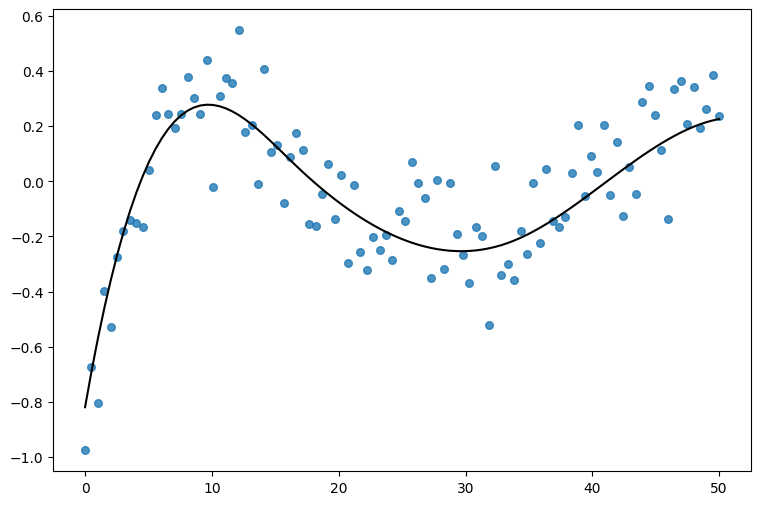

In [2]:
rng = np.random.default_rng(seed=121195)

N = 100
x = np.linspace(0, 50, N)
b = 0.1 * rng.normal(size=6)
sigma_t = 0.15

dm = design_matrices("0 + bs(x, df=6, intercept=True)", pd.DataFrame({"x": x}))
X = np.array(dm.common)
f = 10 * X @ b
y = f + sigma_t * rng.normal(size=N)

fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(x, y, s=30, alpha=0.8);
ax.plot(x, f, color="black");

In [3]:
df = pd.DataFrame({"x": x, "y": y})
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=2),
    "ell": bmb.Prior("InverseGamma", mu=10, sigma=1)
}
priors = {
    "hsgp(x, m=10, c=2, centered=True)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=10)
}
model = bmb.Model("y ~ 0 + hsgp(x, m=10, c=2, centered=True)", df, priors=priors)
model.set_alias({"hsgp(x, m=10, c=2, centered=True)": "hsgp"})

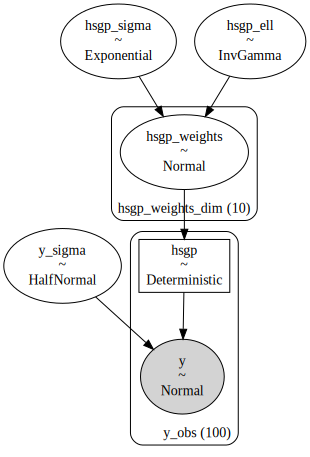

In [4]:
model.build()
model.graph()

In [5]:
idata = model.fit(inference_method="nuts_numpyro")
print(idata.sample_stats["diverging"].sum().to_numpy())

/home/tomas/anaconda3/envs/bambi_hsgp/lib/python3.10/site-packages/pymc/sampling/jax.py:39: UserWarning: This module is experimental.
  warnings.warn("This module is experimental.")


Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:00:02.426626
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.460844
Transforming variables...
Transformation time =  0:00:00.204223
0


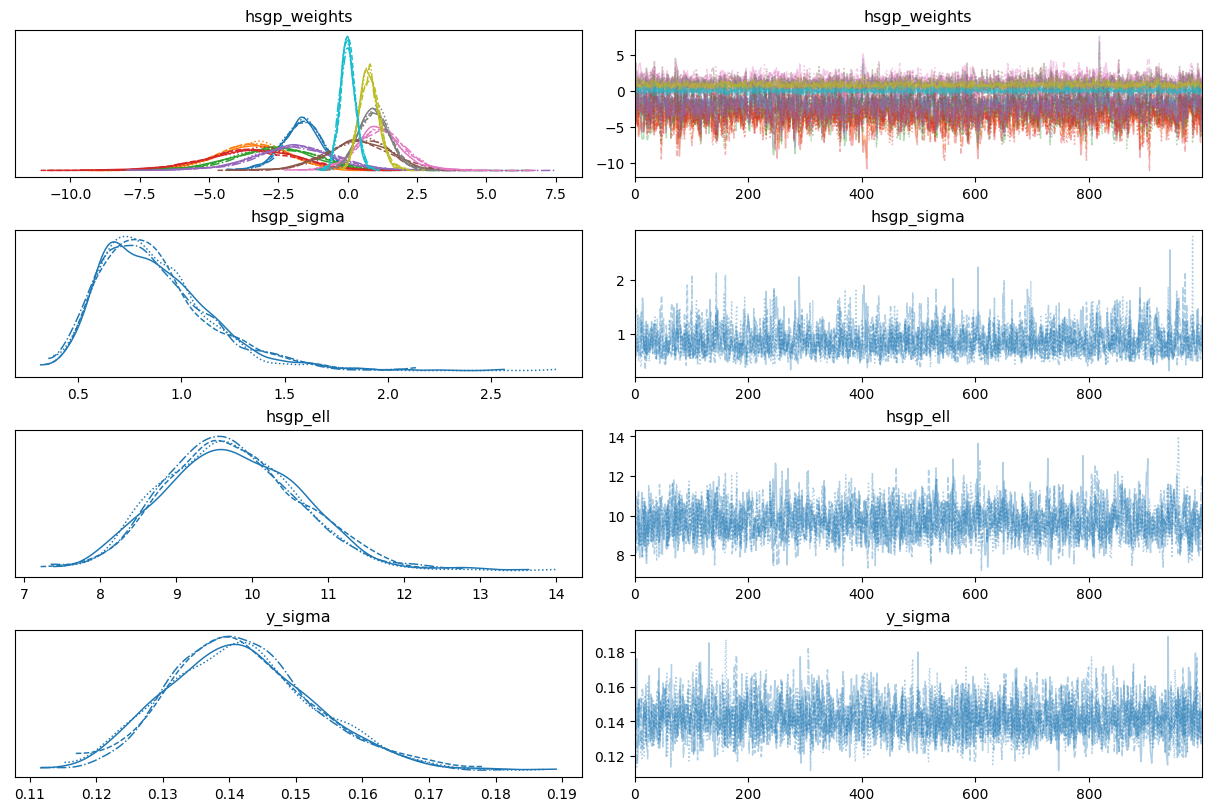

In [6]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

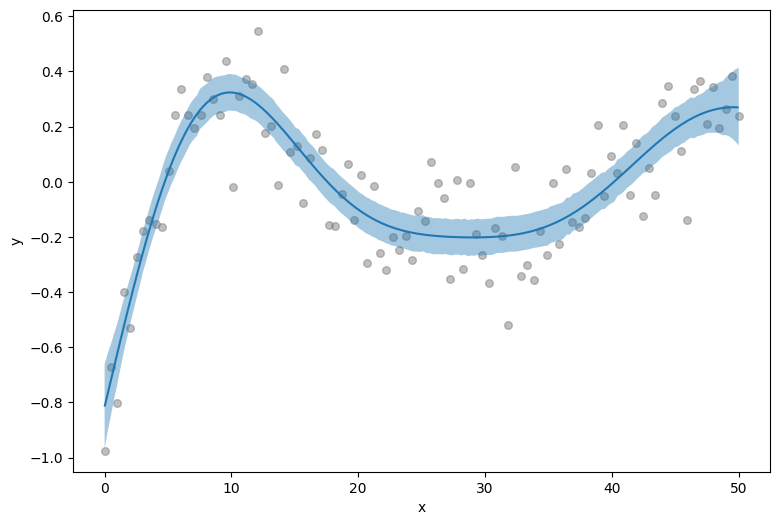

In [7]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(df["x"], df["y"], s=30, color="0.5", alpha=0.5)
plot_cap(model, idata, "x", ax=ax);

In [8]:
x_new = np.linspace(-10, 70, 500)
model.predict(idata, kind="pps", data=pd.DataFrame({"x": x_new}))
f_new = idata.posterior_predictive["y"].stack(sample=("chain", "draw")).T.to_numpy()

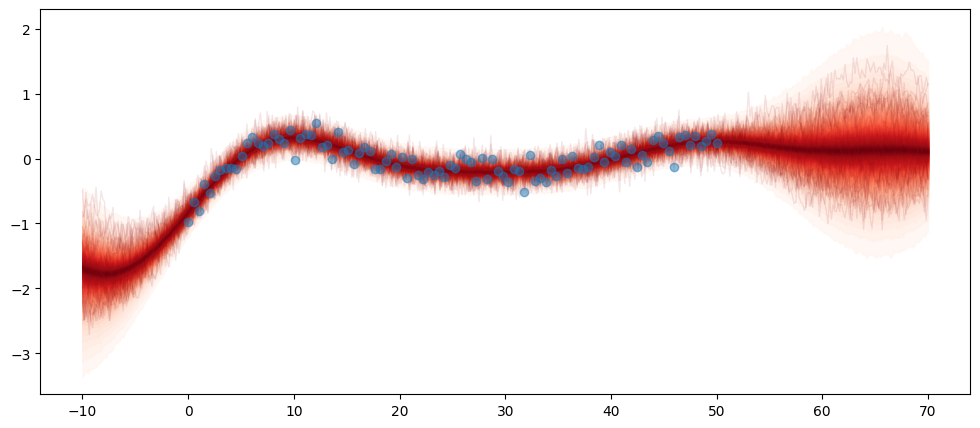

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.scatter(x, y, alpha=0.5, zorder=10)
pm.gp.util.plot_gp_dist(ax, f_new, x_new);

---

## HSGP by levels of a categorical covariate

In [10]:
data = pd.read_csv("gam_data.csv")
data["fac"] = pd.Categorical(data["fac"])
data.head()[["x2", "y", "fac"]]

,x2,y,fac
0,0.497183,3.085274,3
1,0.196003,-2.250410,2
2,0.958474,0.070548,3
3,0.972759,-0.230454,1
4,0.755836,2.173497,2


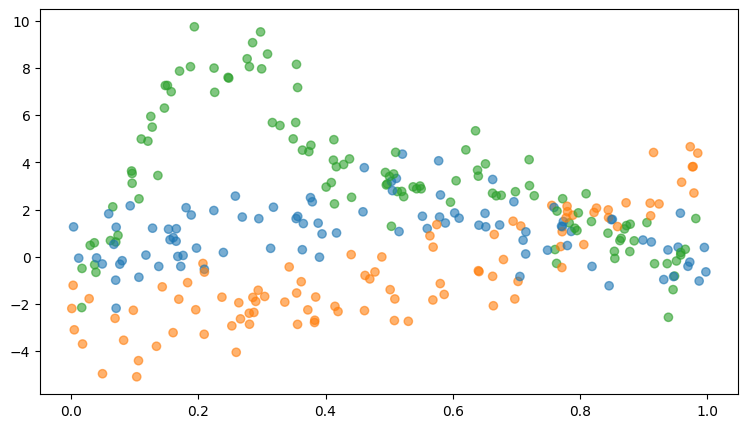

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6);

In [12]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=3),
    "ell": bmb.Prior("Exponential", lam=3)
}
priors = {
    "hsgp(x2, by=fac, m=12, c=1.5)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5)", data, priors=priors)
model.set_alias({"hsgp(x2, by=fac, m=12, c=1.5)": "hsgp"})

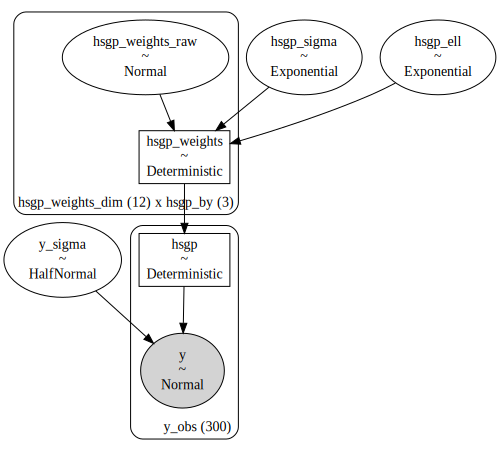

In [13]:
model.build()
model.graph()

In [14]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.95)
print(idata.sample_stats.diverging.sum().item())

Compiling...
Compilation time =  0:00:03.364688
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.528482
Transforming variables...
Transformation time =  0:00:00.855105
0


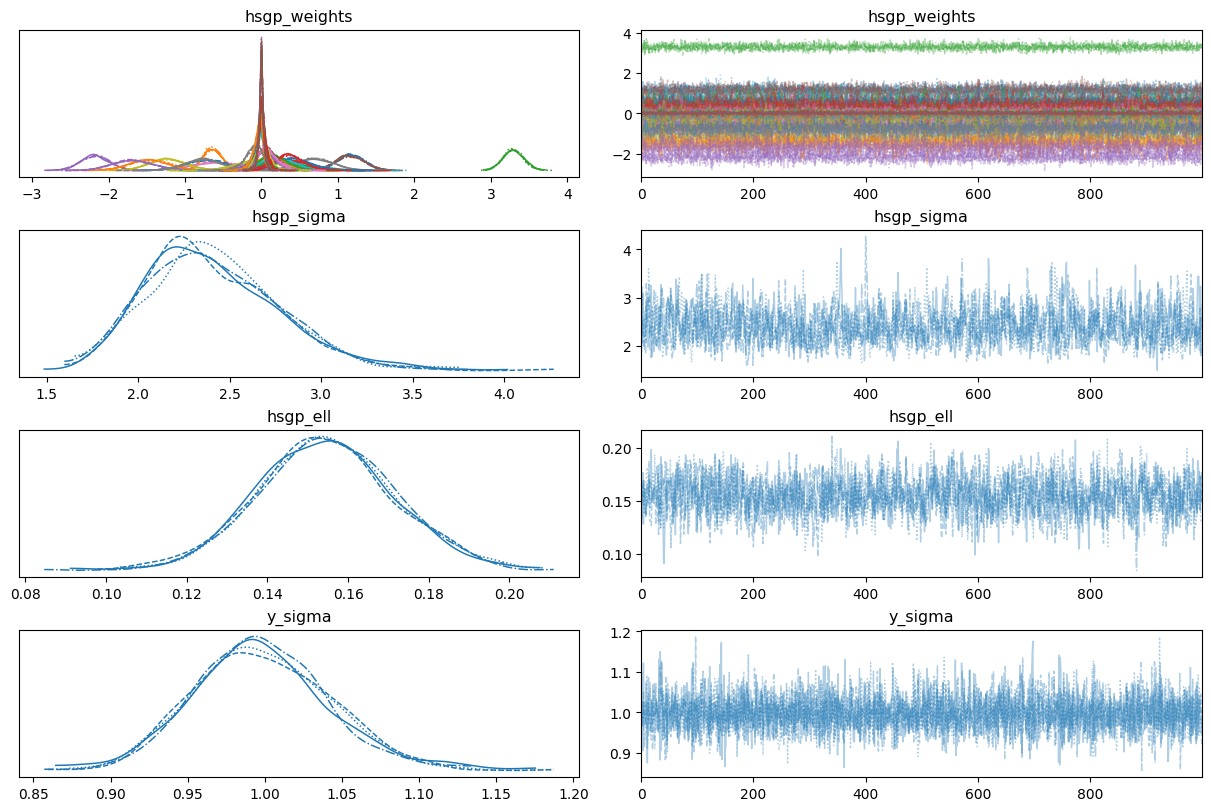

In [15]:
az.plot_trace(
    idata, 
    var_names=["hsgp_weights", "hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

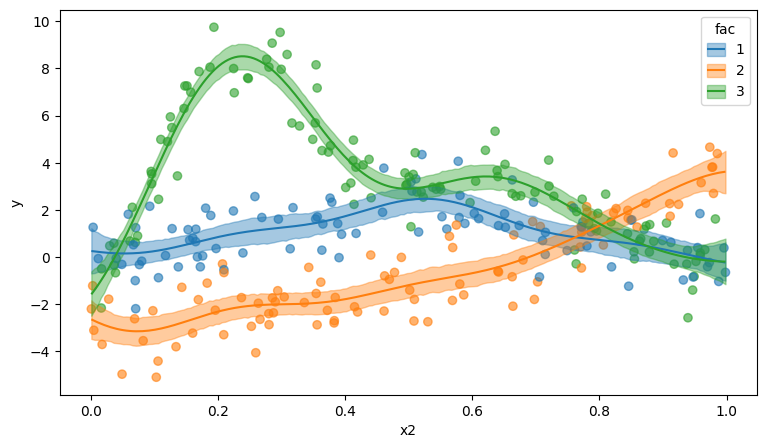

In [16]:
fig, ax = plt.subplots(figsize = (9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6)
plot_cap(model, idata, ["x2", "fac"], ax=ax);

Now use a different covariance functions for every group.

In [21]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=1),
    "ell": bmb.Prior("Exponential", lam=3)
}
priors = {
    "hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)": prior_hsgp,
    "sigma": bmb.Prior("HalfNormal", sigma=1)
}
model = bmb.Model("y ~ 0 + hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)", data, priors=priors)
model.set_alias({"hsgp(x2, by=fac, m=12, c=1.5, share_cov=False)": "hsgp"})

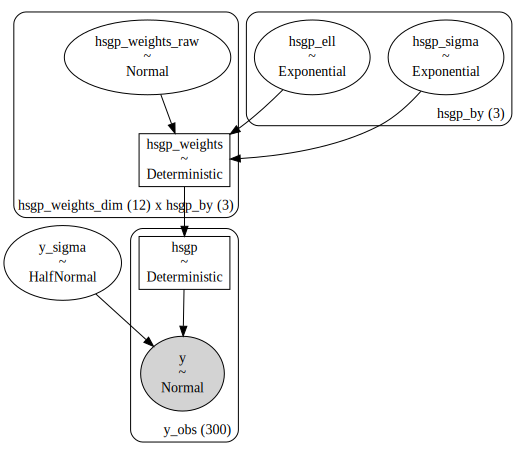

In [22]:
model.build()
model.graph()

In [23]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.95)

Compiling...
Compilation time =  0:00:04.245721
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:06.756189
Transforming variables...
Transformation time =  0:00:00.427903


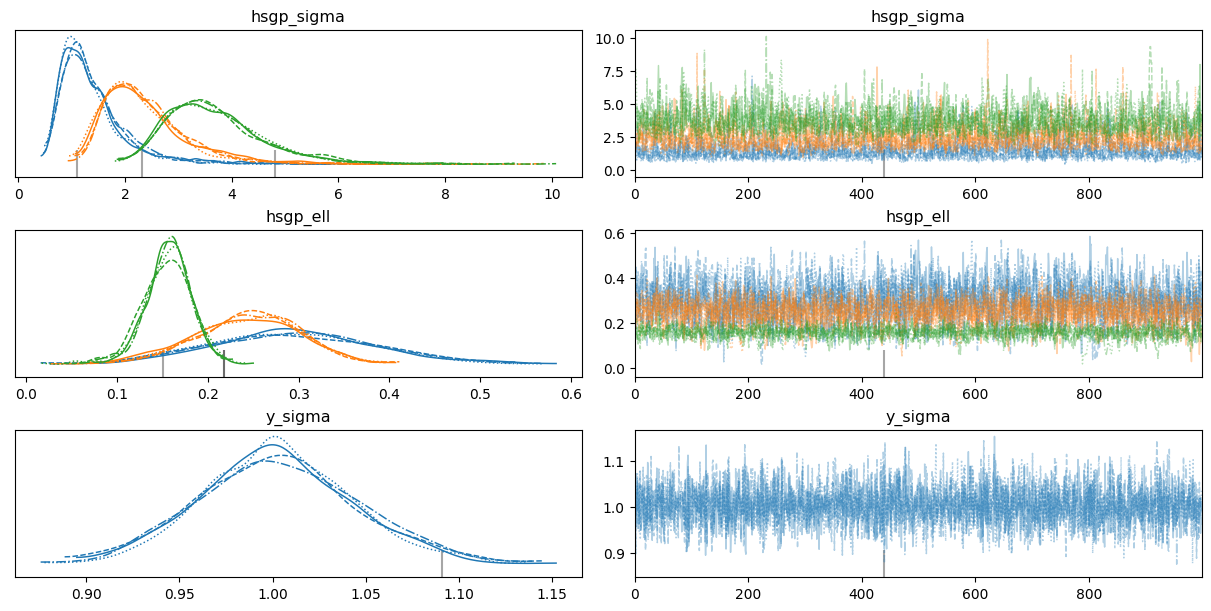

In [24]:
az.plot_trace(
    idata, 
    var_names=["hsgp_sigma", "hsgp_ell", "y_sigma"], 
    backend_kwargs={"layout": "constrained"}
);

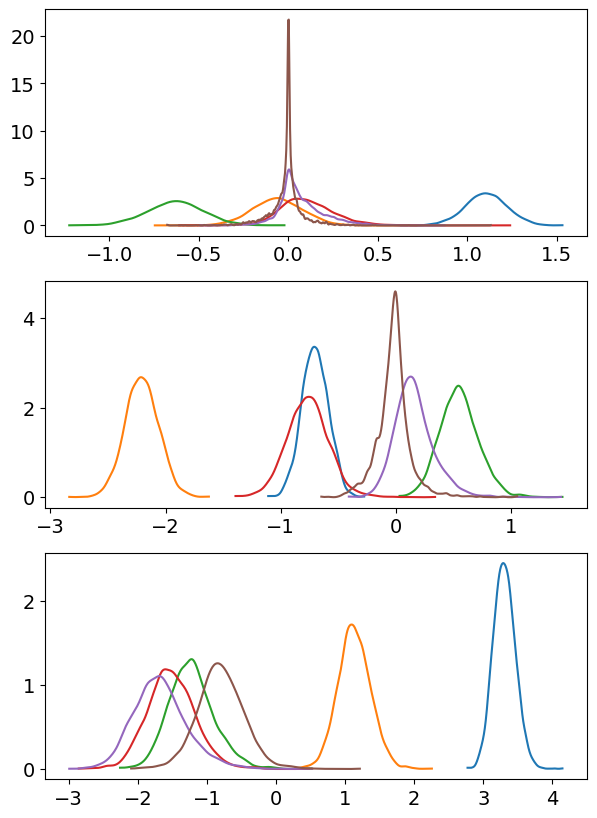

In [25]:
fig, axes = plt.subplots(3, 1, figsize = (7, 10))
for i in range(3):
    ax = axes[i]
    values = idata.posterior["hsgp_weights"].sel({"hsgp_by": i + 1})
    for j in range(6):
        az.plot_kde(
            values.sel({"hsgp_weights_dim": j}).to_numpy().flatten(), 
            ax=ax, 
            plot_kwargs={"color": f"C{j}"}
        );

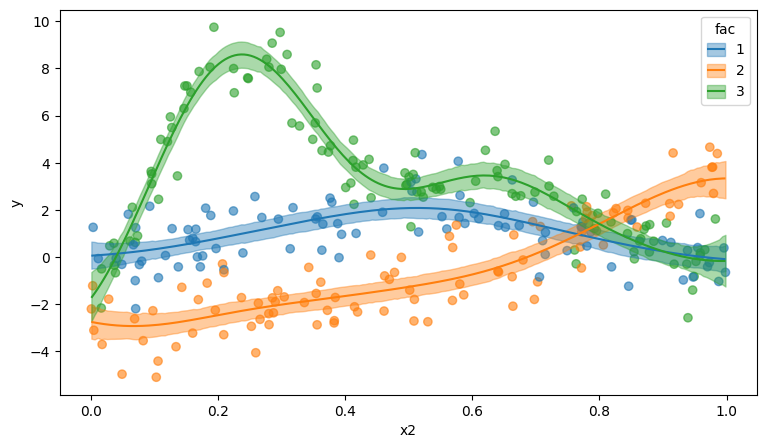

In [26]:
fig, ax = plt.subplots(figsize=(9, 5))
colors = [f"C{i}" for i in pd.Categorical(data["fac"]).codes]
ax.scatter(data["x2"], data["y"], color=colors, alpha=0.6)
plot_cap(model, idata, ["x2", "fac"], ax=ax);

---

## 2D HSGP

In [27]:
import pymc as pm

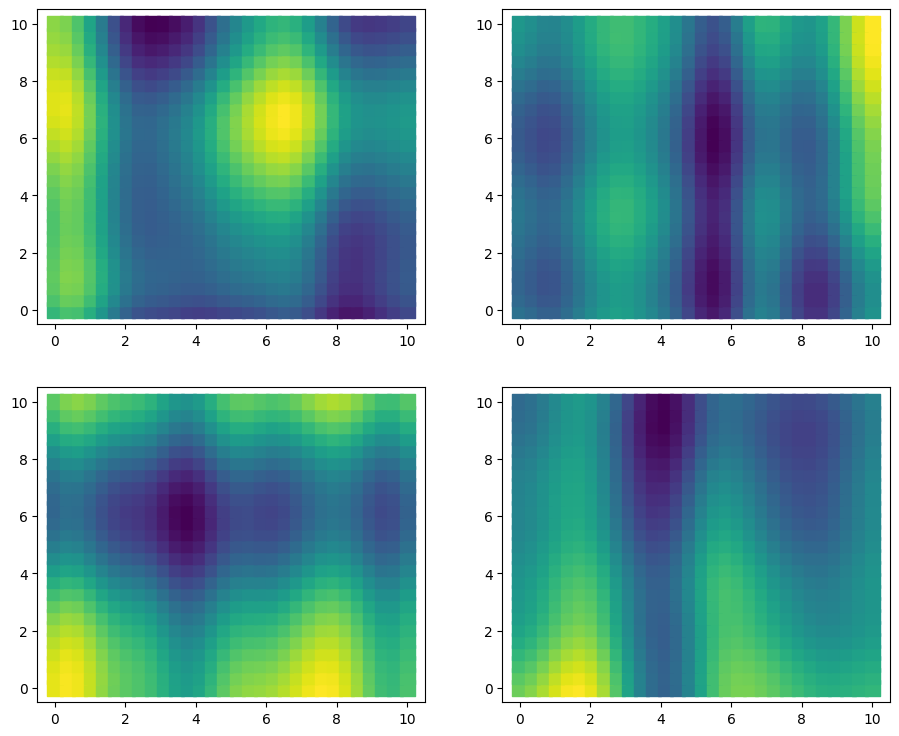

In [28]:
rng = np.random.default_rng(seed=1234)

# make X grid
x1 = np.linspace(0, 10, 30)
x2 = np.linspace(0, 10, 25)
xx, yy = np.meshgrid(x1, x2)
X = np.concatenate((yy.flatten()[:, None], xx.flatten()[:, None]), axis=1)

## row and range "factors"
ell_row = 2
cov_row = pm.gp.cov.ExpQuad(2, ls=ell_row, active_dims=[0])

ell_range = 1
cov_range = pm.gp.cov.ExpQuad(2, ls=ell_range, active_dims=[1])

## anisotropic
ell_anisotropic = [4, 2] # row and range lengthscales in product cov
cov_anisotropic = pm.gp.cov.ExpQuad(2, ls=ell_anisotropic)

cov = cov_row + cov_range + cov_anisotropic
K = cov(X).eval()

ff = rng.multivariate_normal(np.zeros(X.shape[0]), K, 4).T

fig, axs = plt.subplots(2, 2, figsize=(11, 9)); 
axs = axs.flatten()
for i, ax in enumerate(axs):
    ax.scatter(xx, yy, c=ff[:, i], s=120, marker="s")
    ax.grid(False) 

In [29]:
y = yy.flatten()
x = xx.flatten()
f = ff[:, 0]

df = pd.DataFrame({"x": x, "y": y, "f": f})
df.head()

,x,y,f
0,0.000000,0.0,2.783611
1,0.344828,0.0,3.131854
2,0.689655,0.0,3.055532
3,1.034483,0.0,2.536763
4,1.379310,0.0,1.749508


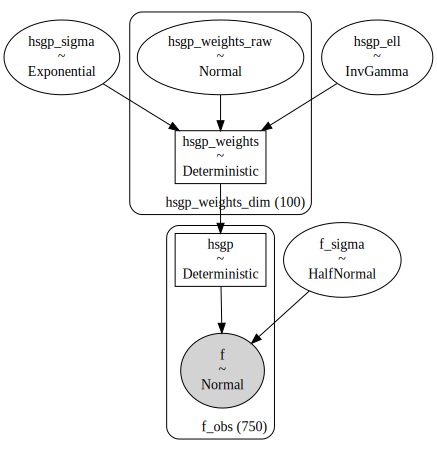

In [30]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=1),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.5),
}
priors = {"hsgp(x, y, m=10, c=1.5)": prior_hsgp, "sigma": bmb.Prior("HalfNormal", sigma=1)}
model = bmb.Model("f ~ 0 + hsgp(x, y, m=10, c=1.5)", df, priors=priors)
model.set_alias({"hsgp(x, y, m=10, c=1.5)": "hsgp"})
model.build()
model.graph()

In [31]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)

Compiling...
Compilation time =  0:00:02.008531
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:10.468613
Transforming variables...
Transformation time =  0:00:00.546363


In [32]:
idata.sample_stats.diverging.sum().item()

0

In [33]:
az.summary(idata, var_names=["hsgp_sigma", "hsgp_ell"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hsgp_sigma,2.358,0.362,1.744,3.066,0.019,0.013,363.0,780.0,1.01
hsgp_ell,1.773,0.063,1.650,1.883,0.003,0.002,514.0,1312.0,1.01


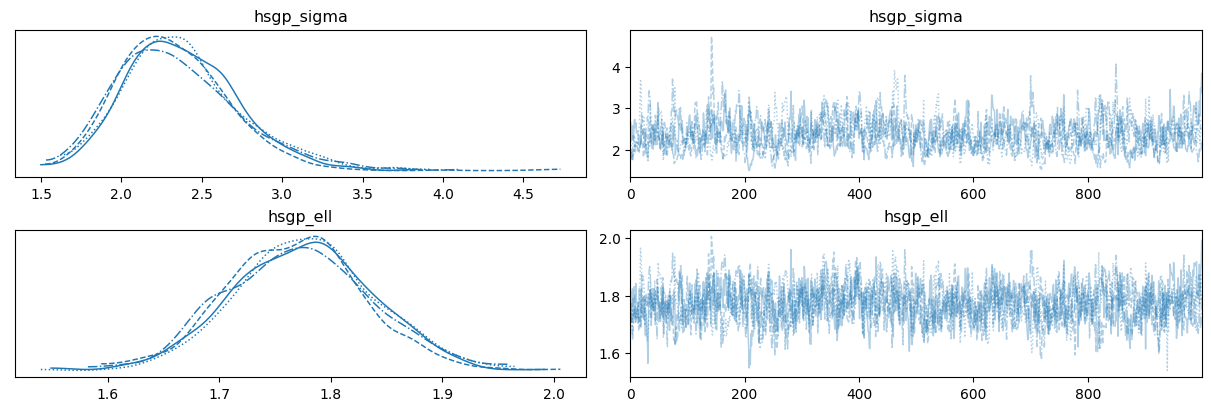

In [34]:
az.plot_trace(idata, var_names=["hsgp_sigma", "hsgp_ell"], backend_kwargs={"layout": "constrained"});

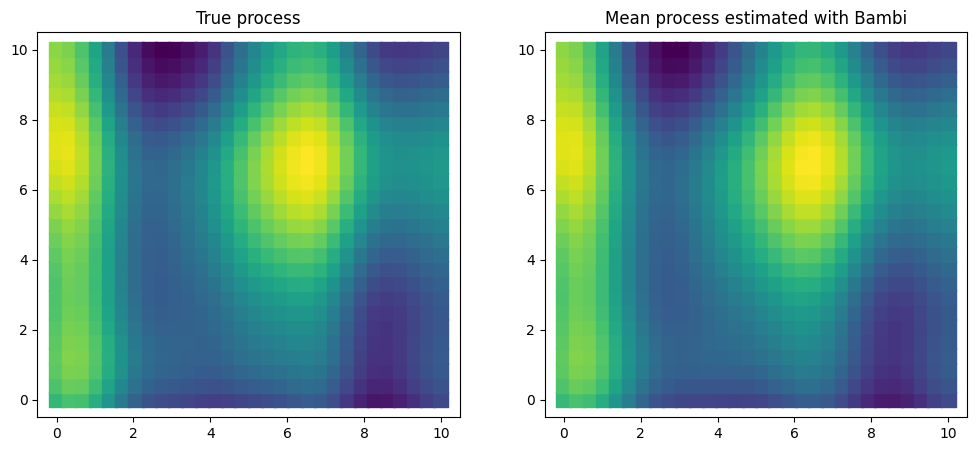

In [35]:
f_mean = idata.posterior["hsgp"].mean(("chain", "draw")).to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(xx, yy, c=ff[:, 0], s=120, marker="s")
axes[1].scatter(df["x"], df["y"], c=f_mean, s=120, marker="s")

axes[0].set_title("True process")
axes[1].set_title("Mean process estimated with Bambi")
axes[0].grid(False)
axes[1].grid(False)

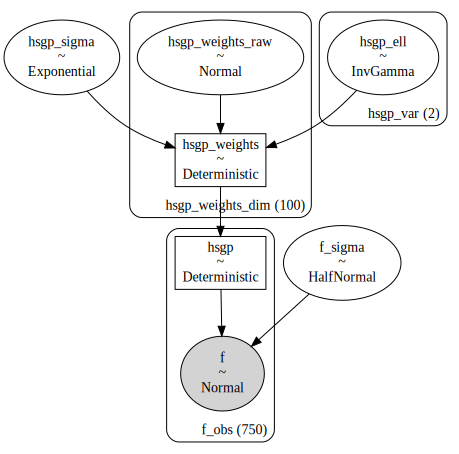

In [36]:
prior_hsgp = {
    "sigma": bmb.Prior("Exponential", lam=1),
    "ell": bmb.Prior("InverseGamma", mu=2, sigma=0.5),
}
priors = {"hsgp(x, y, m=10, c=1.5, iso=False)": prior_hsgp, "sigma": bmb.Prior("HalfNormal", sigma=1)}
model = bmb.Model("f ~ 0 + hsgp(x, y, m=10, c=1.5, iso=False)", df, priors=priors)
model.set_alias({"hsgp(x, y, m=10, c=1.5, iso=False)": "hsgp"})
model.build()
model.graph()

In [37]:
idata = model.fit(inference_method="nuts_numpyro", target_accept=0.9)
print(idata.sample_stats.diverging.sum().to_numpy())

Compiling...
Compilation time =  0:00:02.861638
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:19.974858
Transforming variables...
Transformation time =  0:00:00.200254
0


In [38]:
az.summary(idata, var_names=["hsgp_sigma", "hsgp_ell"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
hsgp_sigma,2.164,0.325,1.562,2.767,0.019,0.013,306.0,605.0,1.02
hsgp_ell[0],1.602,0.078,1.456,1.746,0.003,0.002,497.0,960.0,1.02
hsgp_ell[1],2.173,0.066,2.052,2.297,0.003,0.002,603.0,1341.0,1.01


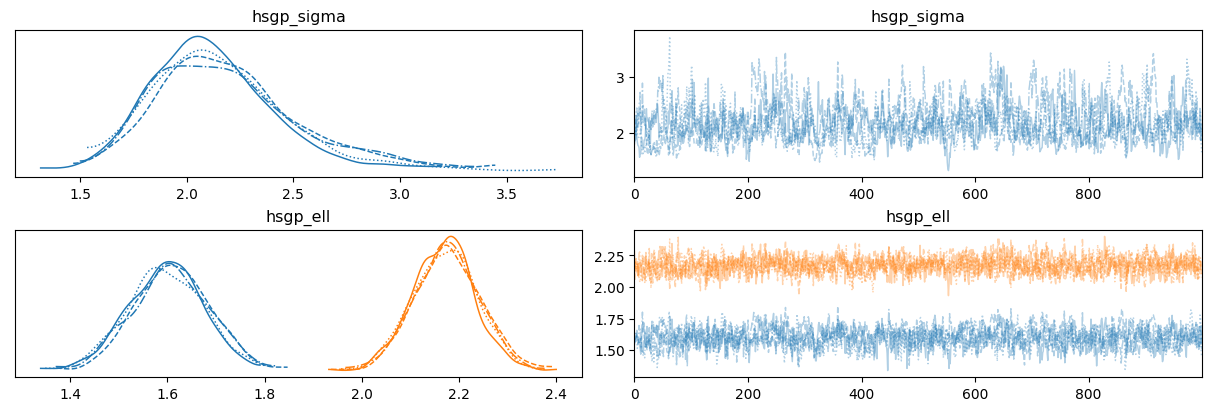

In [39]:
az.plot_trace(idata, var_names=["hsgp_sigma", "hsgp_ell"], backend_kwargs={"layout": "constrained"});

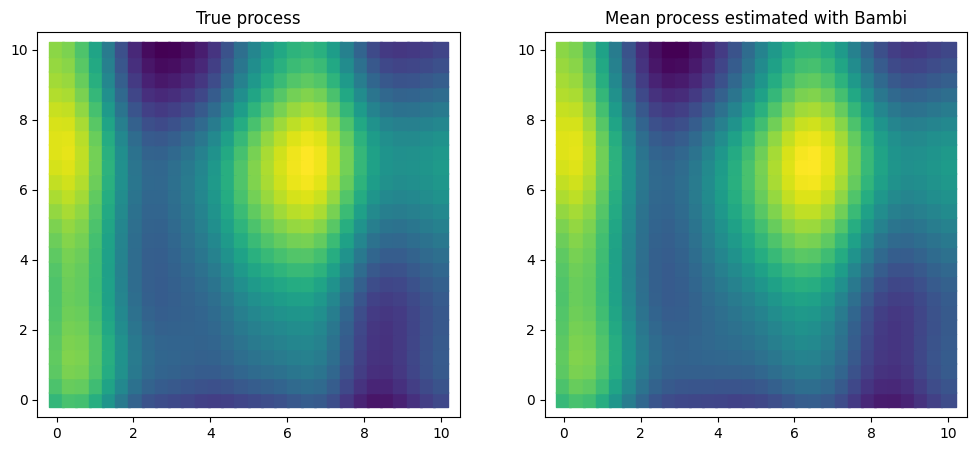

In [40]:
f_mean = idata.posterior["hsgp"].mean(("chain", "draw")).to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(xx, yy, c=ff[:, 0], s=120, marker="s")
axes[1].scatter(df["x"], df["y"], c=f_mean, s=120, marker="s")

axes[0].set_title("True process")
axes[1].set_title("Mean process estimated with Bambi")
axes[0].grid(False)
axes[1].grid(False)

https://towardsdatascience.com/tree-boosting-for-spatial-data-789145d6d97d

In [2]:
import numpy as np
np.random.seed(1)
# Simulate Gaussian process: training and test data (the latter on a grid for visualization)
sigma2_1 = 0.35  # marginal variance of GP
rho = 0.1  # range parameter
sigma2 = 0.1  # error variance
n = 200  # number of training samples
nx = 50 # test data: number of grid points on each axis
# training locations (exclude upper right rectangle)
coords = np.column_stack((np.random.uniform(size=1)/2, np.random.uniform(size=1)/2))

while coords.shape[0] < n:
    coord_i = np.random.uniform(size=2)
    if not (coord_i[0] >= 0.6 and coord_i[1] >= 0.6):
        coords = np.vstack((coords,coord_i))


# test locations (rectangular grid)
s_1 = np.ones(nx * nx)
s_2 = np.ones(nx * nx)
for i in range(nx):
  for j in range(nx):
    s_1[j * nx + i] = (i + 1) / nx
    s_2[i * nx + j] = (i + 1) / nx

coords_test = np.column_stack((s_1, s_2))
n_all = nx**2 + n # total number of data points 
coords_all = np.vstack((coords_test,coords))
D = np.zeros((n_all, n_all))  # distance matrix

for i in range(0, n_all):
  for j in range(i + 1, n_all):
    D[i, j] = np.linalg.norm(coords_all[i, :] - coords_all[j, :])
    D[j, i] = D[i, j]

Sigma = sigma2_1 * np.exp(-D / rho) + np.diag(np.zeros(n_all) + 1e-10)
C = np.linalg.cholesky(Sigma)
b_all = C.dot(np.random.normal(size=n_all))
b_train = b_all[(nx * nx):n_all] # training data GP

# Mean function. Use two predictor variables of which only one has an effect for easy visualization
def f1d(x):
  return np.sin(3 * np.pi * x) + (1 + 3 * np.maximum(np.zeros(len(x)),x-0.5)/(x-0.5)) - 3

X = np.random.rand(n, 2)
F_X_train = f1d(X[:, 0]) # mean
xi_train = np.sqrt(sigma2) * np.random.normal(size=n)  # simulate error term
y = F_X_train + b_train + xi_train  # observed data

# test data
x = np.linspace(0,1,nx**2)
x[x==0.5] = 0.5 + 1e-10
X_test = np.column_stack((x,np.zeros(nx**2)))
F_X_test = f1d(X_test[:, 0])
b_test = b_all[0:(nx**2)]
xi_test = np.sqrt(sigma2) * np.random.normal(size=(nx**2))
y_test = F_X_test + b_test + xi_test

In [10]:
import matplotlib.pyplot as plt

In [16]:
y.shape

(200,)

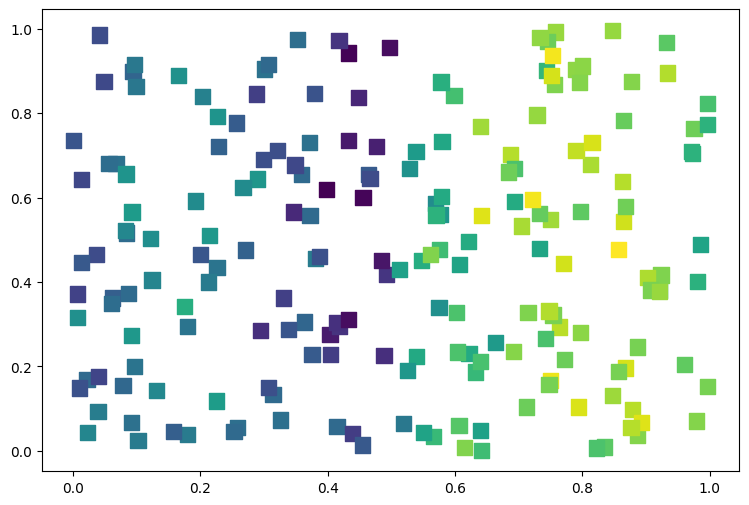

In [21]:
fig, ax = plt.subplots(figsize=(9, 6))
ax.scatter(X[:, 0].flatten(), X[:, 1].flatten(), c=y, s=120, marker="s")
# axes[0].set_title("True process")
# axes[1].set_title("Mean process estimated with Bambi")
# axes[0].grid(False)
# axes[1].grid(False)